# Classification of Cancer associated Mutations from Literature using Machine Learning

Use the "Run" button to execute the code.

In [9]:
pip install jovian --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None
distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None


In [10]:
# Execute this to save new versions of the notebook
jovian.commit(project="jovian-ml-project-030122",filename="jovian-ml-project-030122")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "anubratadas/jovian-ml-project-030122" on https://jovian.ai/
[jovian] Committed successfully! https://jovian.ai/anubratadas/jovian-ml-project-030122


'https://jovian.ai/anubratadas/jovian-ml-project-030122'

### <font color='green'>Import the essential libraries</font>

In [11]:
import jovian
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
import time
import re
from tqdm import tqdm
%matplotlib inline

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore')

In [13]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [14]:
tqdm.pandas(desc="progress bar")

 ### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"> A cancerous tissue can have thousands of genetic mutations (Variations), which are discovered using genome sequencing. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations. MSKCC intends the Data scientist to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.</font>

<a id='top'>**Beginning of Notebook**</a>

[model train text data](#train_data)

### <font color='green'>Exploratory Data Analysis</font>

###  references
  - https://github.com/ghostintheshellarise/2021HackForRare
  - https://widdowquinn.github.io/2018-03-06-ibioic/02-sequence_databases/09-KEGG_programming.html
  - https://bioservices.readthedocs.io/en/master/kegg_tutorial.html
  - https://bioservices.readthedocs.io/en/master/index.html

#### train data

In [15]:
train_text_df = pd.read_csv('training_text.zip', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"],compression='zip')

In [16]:
train_variant_df = pd.read_csv('training_variants.zip',compression='zip')

In [17]:
train_text_df.shape, train_variant_df.shape

((3321, 2), (3321, 4))

In [18]:
train_text_df.columns, train_variant_df.columns

(Index(['ID', 'Text'], dtype='object'),
 Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object'))

In [19]:
# merging the text and variation data
train_df = pd.merge(train_variant_df,train_text_df,on='ID')

In [20]:
train_text_df.head(n=4)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...


In [21]:
train_variant_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [22]:
train_df.shape

(3321, 5)

In [23]:
# taking a sample of the dataset
#train_df = train_df.sample(frac=0.6,random_state=222)

We have taken a sample of the training data

In [24]:
train_df.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


![](https://imgur.com/kO8UAXb.png)

image courtesy http://igbiologyy.blogspot.com/2014/03/chromosomes-dna-genes-and-alleles.html

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"><i>Gene</i> is a stretch of DNA encoding a specific functional molecule, a protein. Variation is <i>Mutation</i>,  which occurs in the gene and changes the function of the protein. Proteins are made up of 20 amino acids and these are designated by the following alphabets; A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y and V. In the variation column, the first alphabet is the orginal amino acid, the number is the physical position in the gene where the change has occured and the last alphabet is the changed amino acid. The Text dataset contains the information for the Gene, the Variation and the Class column in the variants dataset. The 2 datasets are linked by the common ID column</font>

### The distribution of mutations per gene in the dataset

In [25]:
mutation_pattern=train_df.groupby(['Gene'])[['Variation']].aggregate("count").sort_values("Variation",ascending=False)

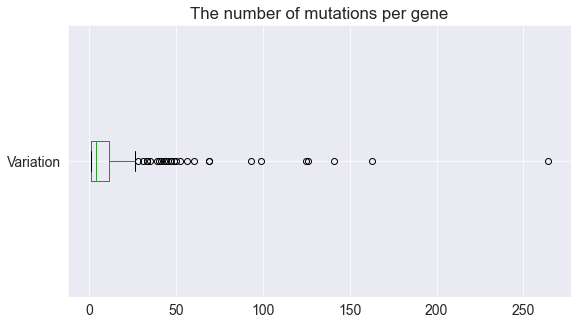

In [26]:
mutation_pattern[['Variation']].boxplot(vert=False);
plt.title("The number of mutations per gene");

In [27]:
mutation_pattern.shape

(264, 1)

In [28]:
mutation_pattern['Variation'].median()

4.0

In [29]:
mutation_pattern['Variation'].mode()

0    1
dtype: int64

In [30]:
from scipy.special import factorial

def poisson(k, lamb):
    """poisson pdf, parameter lamb is the fit parameter"""
    return (lamb**k/factorial(k)) * np.exp(-lamb)

In [31]:
lamb=mutation_pattern['Variation'].mean()

In [32]:
k=mutation_pattern['Variation'].to_numpy()

In [33]:
k=np.sort(k)

In [34]:
y=poisson(k,lamb)

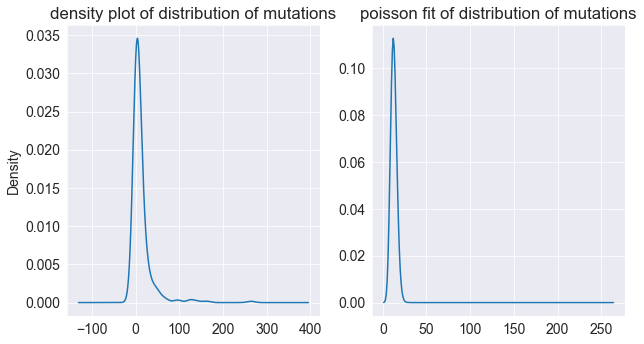

In [35]:
plt.subplot(1,2,1)
mutation_pattern['Variation'].plot.density();
plt.title("density plot of distribution of mutations")
plt.subplot(1,2,2)
plt.plot(k,y);
plt.title("poisson fit of distribution of mutations")
plt.tight_layout()

In [36]:
mutated_genes=train_df['Gene'].to_list()

### <font style="font-size:18px;font-family:arial;color:blue;text-indent:100px;line-height: 0.8;word-spacing: 10px"> Mutation acquisition is a rare event. The Poisson distribution is used to describe the distribution of rare events in a large population. For example, at any particular time, there is a certain probability that a particular cell within a large population of cells will acquire a mutation.                                                                                   -Frank H. Stephenson, in Calculations for Molecular Biology and Biotechnology (Second Edition), 2010. The distribution of mutations per gene in this dataset follows the usual pattern of Poisson distribution seen in general for mutations. 3321 mutations, or variations, are distributed in 195 genes. 14 genes have more than 20 mutations, which are often classified in different classes. It would be worthwhile to investigate, why certain mutations are classified in certain specific classes </font>

### <font color='green'>The distribution of classes in the dataset </font>

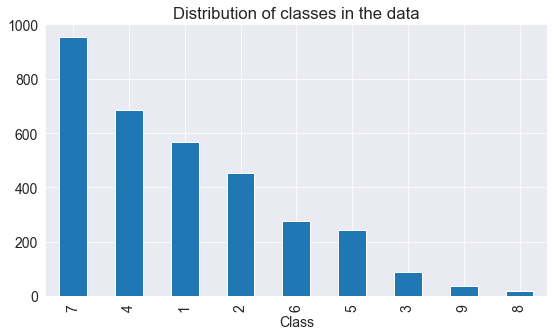

In [37]:
train_df.value_counts('Class').plot(kind='bar');
plt.title("Distribution of classes in the data");

### <font color='blue'>The mutations are distributed into 9 classes, from class 1 to class 9.The distribution of the classes is imbalanced </font>

In [38]:
train_df[train_df['Class']==8]['Gene'].nunique()

12

In [43]:
train_df[train_df['Class']==7]['Gene'].nunique()

108

### <font color="blue"> The largest class, class 7, has 108 genes which is almost half of all the mutated genes, while class 8, the smallest class has 12 genes. Let us see if all genes in class 7 have the same number of mutations per gene </font>

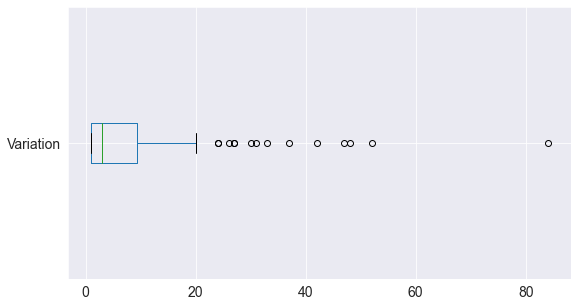

In [63]:
train_df[train_df['Class']==7].groupby('Gene')[['Variation']].count().boxplot(vert=False);

In [69]:
train_df[train_df['Class']==7]['Variation'].nunique()

889

### <font color='blue'> The pattern of mutations per gene is same as the overall dataset and hence,no obvious numerical pattern is present in classifying the mutations in class 7. Let us furthere explore a few other possibilites for the classification </font>

### <font color='green'>The Signalling Pathways in Cancer</font>

![](https://i.imgur.com/yk4ib0M.jpg)

In [40]:
#!pip install biopython

In [41]:
#!pip install bioservices

In [42]:
#from Bio import SeqIO
from Bio.KEGG import REST
from bioservices.kegg import KEGG
#from collections import deque
import networkx as nx
from IPython.display import Image
import time
import io
import os

In [ ]:
print(REST.kegg_info('pathway').read())

In [ ]:
kegg_obj=KEGG()

In [ ]:
print(kegg_obj.get("hsa:ALK"))

In [ ]:
print(kegg_obj.find("hsa","ALK")[:300])

In [ ]:
print(REST.kegg_get('hsa:ALK','aaseq').read()[:300])

In [ ]:
print(kegg_obj.get_pathway_by_gene("238","hsa"))

In [ ]:
human_gene_list=kegg_obj.list('hsa')

In [ ]:
human_gene_list=human_gene_list.split('\n')

In [ ]:
import re

In [ ]:
human_gene_list[0]

In [ ]:
re.sub('[\t;]',',',human_gene_list[0])

In [ ]:
re.search('^\w+:\w+','hsa:100616498\tMIR378E, mir-378e; microRNA 378e')

In [ ]:
re.search('\t\w+','hsa:100616498\tMIR378E, mir-378e; microRNA 378e').group()[1:]

In [ ]:
def get_kegg_indices(human_gene_list):
    gene_kegg_id_dict={}
    for item in human_gene_list:
        try:
            kegg_id=re.search('^\w+:\w+',item).group()
        except:
            kegg_id='no_entry'
        try:
            gene=re.search('\t\w+',item).group()[1:]
        except:
            gene='no_gene'            
        gene_kegg_id_dict[gene]=kegg_id
    return gene_kegg_id_dict    

In [ ]:
def map_mutation_kegg(mutated_genes,human_gene_list):
    print("mutated genes",len(mutated_genes))
    print("kegg genes",len(human_gene_list))
    mut_gene_kegg=[]
    kegg_gene_dict=get_kegg_indices(human_gene_list)
    for mut_gene in mutated_genes:
        if mut_gene in kegg_gene_dict:
            gene_tup=(mut_gene,kegg_gene_dict[mut_gene])
            mut_gene_kegg.append(gene_tup)
    return mut_gene_kegg        

In [ ]:
mutated_kegg=map_mutation_kegg(mutated_genes,human_gene_list)

In [ ]:
print(kegg_obj.get_pathway_by_gene("BRCA2","hsa"))

In [ ]:
test=mutated_genes[:6]

In [ ]:
def df_gene_pathway():    
    df_gene_pathway=pd.DataFrame(columns=["gene","pathway"])
    for gene in tqdm(mutated_genes):    
        try:
            pathway_origin=kegg_obj.get_pathway_by_gene(gene,"hsa")
            pathway_list=list(set(pathway_origin.keys()))
            for pathway in pathway_list:
                df_gene_pathway=df_gene_pathway.append({"pathway":pathway,"gene":gene},ignore_index=True)
        except:
            print("no data for ",gene)
    return df_gene_pathway       

In [ ]:
gene_pathway=df_gene_pathway()

In [ ]:
gene_pathway.shape

In [ ]:
gene_pathway.head()

In [ ]:
gene_pathway.drop_duplicates(inplace=True)

In [ ]:
gene_pathway.shape

In [ ]:
from sklearn import preprocessing

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
gene_pathway_matrix=gene_pathway.apply(le.fit_transform)
#OneHotEncoder().fit_transform(df)

In [ ]:
gene_pathway_matrix.head()

In [ ]:
gene_pathway_matrix.describe()

In [ ]:
# plot
ax=plt.scatter(
   gene_pathway_matrix.iloc[:,0],gene_pathway_matrix.iloc[:,1],
   c='white', marker='o',
   edgecolor='black', s=50
)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title("genes vs pathways")
plt.show()

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(gene_pathway_matrix)

In [ ]:
import networkx as nx

In [ ]:
print(plt.rcParams.get('figure.figsize'))

In [ ]:
plt.rcParams["figure.figsize"] = [12.0,10.0]

In [ ]:
G = nx.from_pandas_edgelist(gene_pathway,source="gene",target="pathway")

In [ ]:
nx.draw_networkx(G,alpha=0.6)

### <font color='green'> Let us study the mutations of BRCA1, the most highly mutated gene with respect to the classification</font>

In [ ]:
train_df[train_df['Gene'] == 'BRCA1']['Variation'].nunique()

In [ ]:
train_df[train_df['Gene'] == 'BRCA1']['Class'].nunique()

In [ ]:
train_df[train_df['Gene'] == 'BRCA1'].groupby('Class')['Variation'].count()

### <font color='green'> 101 mutations (Variations) are classified into 5 classes with most mutations in class 5 and least mutations in class 3</font>

In [ ]:
class_5=train_df[(train_df['Gene'] == 'BRCA1') & (train_df['Class']== 5)]
class_5['Text']=class_5['Text'].map(lambda x:x[:80])

In [ ]:
class_5.reset_index(inplace=True,drop=True)

In [ ]:
class_5

In [ ]:
class_5.groupby(['Text','Gene'],sort=False)['Variation'].count().reset_index()

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">What is the relationship of the enlisted mutations (Variation) of a gene and the corresponding 'Text' ? For e.g, for mutations of BCRA1, there are 36 unique mutations assigned to class 5 and the above 10 texts are the basis for it</font>

In [ ]:
train_df.isna().sum()

In [ ]:
train_df[train_df['Text'].map(lambda x:not isinstance(x,str))]

In [ ]:
train_df.dropna(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y_train=train_df['Class']
X_train=train_df.drop('Class',axis=1)
train_df,validation_df,y_train,y_validation=train_test_split(X_train,y_train,test_size=0.3,stratify=y_train)

In [ ]:
train_df.shape,y_train.shape

In [ ]:
set(y_train.tolist())

In [ ]:
validation_df.shape,y_validation.shape

In [ ]:
set(y_validation.tolist())

### <font color='green'>analyzing the train text data</font>

[link to destination](#destination)

In [ ]:
import string
string.punctuation

In [ ]:
revised_punctuation='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [ ]:
revised_punctuation

In [ ]:
#!pip install nltk

In [ ]:
import nltk
nltk.download('words')
from nltk.corpus import words
words=nltk.corpus.words.words()

In [ ]:
len(set(words))

In [ ]:
nltk_words=set(words)

In [ ]:
def cleanse_data(data):        
    if isinstance(data,str):
        no_punctuation = [char for char in data.replace('\n',' ') if char not in revised_punctuation]
        no_punctuation_txt = ''.join(no_punctuation)                   
        return no_punctuation_txt
    else:
        return "NA"

In [ ]:
def reduce_words(data):
    data = data.split()
    words = [word for word in data if word not in nltk_words]
    text = " ".join(words)
    return text    

In [ ]:
def word_count(text):
    text_lst=text.split()
    vector = [text_lst.count(str(word)) for word in text_lst]
    return vector[:300]

In [ ]:
from nltk.probability import FreqDist

we have obtained the frequency distribution of words using freqdist

In [ ]:
def freq_dist(data):
    data=data.split(" ")
    freq=FreqDist(data) # gets word frequency
    freq=sorted(freq.items(),key=lambda x:x[1], reverse=True) # sorts words from highest to lowest frequency
    return [item[1] for item in freq][:300] # returns a fixed length of 300 words

In [ ]:
# implementing bag of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
bow_vectorizer = CountVectorizer(stop_words='english',max_features=1600)

In [ ]:
# implementing tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=1, max_features=1600, strip_accents='unicode',lowercase =True,
    analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english')

In [ ]:
# https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
# https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
# https://www.kaggle.com/elemento/personalizedmedicine-rct

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
# define the multinomial logistic regression model
bow_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
tfidf_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

<a id="train_data" style="font-size:22px">model train text sample data</a>

[Beginning of Notebook](#top)

#### text preprocessing

In [ ]:
# remove punctuation
train_df['cleaned_text'] = train_df['Text'].progress_map(cleanse_data,na_action='ignore')

In [ ]:
# filtering all common english words
train_df['cleaned_text'] = train_df['cleaned_text'].progress_map(reduce_words,na_action='ignore')

In [ ]:
train_df['Text_len'] = train_df['Text'].map(lambda x:len(str(x)))
train_df['cleaned_text_len'] = train_df['cleaned_text'].map(lambda x:len(str(x)))

In [ ]:
train_df.head()

### <font color='green'>converting text to numbers</font>

In [ ]:
train_df_corpus = train_df['cleaned_text'].tolist()

#### bag of words transformation

In [ ]:
bow_vectorizer.fit(train_df_corpus)

In [ ]:
train_df_counts= bow_vectorizer.transform(train_df_corpus)

In [ ]:
print("Vocabulary: ", bow_vectorizer.vocabulary_)

In [ ]:
train_df_counts.shape

In [ ]:
train_df_counts

In [ ]:
X_train_bow = train_df_counts.todense()

In [ ]:
X_train_bow.shape

In [ ]:
X_train_bow

#### tfidf transformation

In [ ]:
tfidf_vectorizer.fit(train_df_corpus)

In [ ]:
X_train_tfidf = tfidf_vectorizer.transform(train_df_corpus)
X_train_tfidf = X_train_tfidf.toarray()

In [ ]:
X_train_tfidf.shape

In [ ]:
X_train_tfidf

### <font color='green'>creating baseline metrics using hard coded predicted values</font>

In [ ]:
from numpy import random

In [ ]:
# create a dummy y value for getting the baseline accuracy
y_dummy_1 = random.rand(926,9)

In [ ]:
#y_dummy

In [ ]:
y_train.head()

In [ ]:
y_dummy_1[0,:]

In [ ]:
# baseline loss metric value, random y values
log_loss(y_train,y_dummy_1)

In [ ]:
y_dummy_2=np.zeros((926,9),dtype='float')

In [ ]:
y_dummy_2[0,:]

In [ ]:
# baseline loss metric value, all probabilites for y set to zero
log_loss(y_train,y_dummy_2)

In [ ]:
# baseline loss metric value, all probabilites for y set to 0.4
y_dummy_3=np.full((926,9),0.4,dtype='float')

In [ ]:
y_dummy_3[0,:]

In [ ]:
log_loss(y_train,y_dummy_3)

In [ ]:
y_dummy_4=np.zeros((926,9),dtype='float')

In [ ]:
y_dummy_4[:,0]=1.0

In [ ]:
y_dummy_4[0,:]

In [ ]:
# baseline loss metric value,probability at index 1 set to 1.0 for all y
log_loss(y_train,y_dummy_4) 

In [ ]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
y_dummy_5=np.zeros((926,9),dtype='float')
count=0
for x in X_train_bow:
    new_y_val=np.random.randint(0,9)
    y_dummy_5[count,new_y_val]=1.    
    count=count+1  

In [ ]:
y_dummy_5[0,:]

In [ ]:
log_loss(y_train,y_dummy_5)

In [ ]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
def get_dummy(train_df):
    y_dummy_5=np.zeros((926,9),dtype='float') # creating the probability matrix for y values
    count=0
    for x in train_df:                        # iterating through the training dataset
        new_y_val=np.random.randint(0,9)      # creating random values for substituting index values
        y_dummy_5[count,new_y_val]=1.         # setting the random index value as 1.0
        count=count+1  
    return y_dummy_5    

In [ ]:
def simulate_dummy(train_df,y_train):    
    for i in range(10):
        y_dummy=get_dummy(train_df)
        print(log_loss(y_train,y_dummy))

In [ ]:
simulate_dummy(train_df,y_train)

In [ ]:
pd.DataFrame({"substitutions":["random","all zero","all 0.4","index 1","random index"],"log_loss":[2.49,2.19,2.19,28.59,2.4]})

### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">Thus the lowermost limit for log loss score for an inaccurate model returns a value of 2.4 and hence our models should return better scores</font> 

### <font color='blue'>Logistic Regression Model</font>

In [ ]:
from sklearn.metrics import accuracy_score

#### <font color='blue'>Logistic Regression with bag of words transformation</font>

In [ ]:
bow_model.fit(X_train_bow,y_train)

In [ ]:
sorted(bow_model.coef_.tolist()[0])[:5]

In [ ]:
bow_model.classes_

In [ ]:
bow_model.n_features_in_

In [ ]:
bow_model.intercept_

In [ ]:
set(y_train.tolist())

In [ ]:
y_pred_train_bow = bow_model.predict_proba(X_train_bow)

In [ ]:
y_pred_train_bow2=bow_model.predict(X_train_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
log_loss(y_train,y_pred_train_bow)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
target_names=['class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']

In [ ]:
print(classification_report(y_train, y_pred_train_bow2, target_names=target_names))

In [ ]:
from sklearn.metrics import plot_confusion_matrix

In [ ]:
plot_confusion_matrix(bow_model, X_train_bow, y_train)

#### <font color='blue'>Logistic Regression with tfidf transformation</font>

In [ ]:
tfidf_model.fit(X_train_tfidf,y_train)

In [ ]:
sorted(tfidf_model.coef_.tolist()[0])[:5]

In [ ]:
tfidf_model.classes_

In [ ]:
tfidf_model.n_features_in_

In [ ]:
tfidf_model.intercept_

In [ ]:
y_pred_train_tfidf = tfidf_model.predict_proba(X_train_tfidf)

In [ ]:
y_pred_train_tfidf2 = tfidf_model.predict(X_train_tfidf)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
log_loss(y_train,y_pred_train_tfidf)

In [ ]:
print(classification_report(y_train, y_pred_train_tfidf2, target_names=target_names))

In [ ]:
plot_confusion_matrix(tfidf_model, X_train_bow, y_train)

### <font color='blue'> Multinomial Naive Bayes Model<font>

In [ ]:
from sklearn.naive_bayes import MultinomialNB

#### <font color='purple'>bag of words transformation</font>

In [ ]:
NB_clf=MultinomialNB()

In [ ]:
NB_clf.fit(X_train_bow,y_train)

In [ ]:
NB_clf.class_count_

In [ ]:
y_pred_train_NB=NB_clf.predict_proba(X_train_bow)

In [ ]:
y_pred_train_NB2=NB_clf.predict(X_train_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
log_loss(y_train,y_pred_train_NB)

In [ ]:
print(classification_report(y_train, y_pred_train_NB2, target_names=target_names))

In [ ]:
plot_confusion_matrix(NB_clf, X_train_bow, y_train)

### Validation dataset

In [ ]:
validation_df.shape,y_validation.shape

In [ ]:
validation_df.head()

#### text processing of validation data

In [ ]:
# remove punctuation
validation_df['cleaned_text'] = validation_df['Text'].progress_map(cleanse_data,na_action='ignore')

In [ ]:
# filtering all common english words
validation_df['cleaned_text'] = validation_df['cleaned_text'].progress_map(reduce_words,na_action='ignore')

In [ ]:
validation_df['Text_len'] = validation_df['Text'].map(lambda x:len(str(x)))
validation_df['cleaned_text_len'] = validation_df['cleaned_text'].map(lambda x:len(str(x)))

In [ ]:
validation_df.head()

In [ ]:
validation_df_corpus = validation_df['cleaned_text'].tolist()

##### Bag of words transformation

In [ ]:
validation_df_counts= bow_vectorizer.transform(validation_df_corpus)

In [ ]:
validation_df_counts.shape

In [ ]:
X_validation_bow = validation_df_counts.todense()

In [ ]:
X_validation_bow.shape

In [ ]:
X_validation_bow[0]

In [ ]:
y_pred_validation_bow = bow_model.predict_proba(X_validation_bow)

In [ ]:
y_pred_validation_bow2 = bow_model.predict(X_validation_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
set(y_validation.tolist())

In [ ]:
log_loss(y_validation,y_pred_validation_bow)

In [ ]:
print(classification_report(y_validation, y_pred_validation_bow2, target_names=target_names))

In [ ]:
plot_confusion_matrix(bow_model, X_validation_bow, y_validation)

##### TFIDF transformation

In [ ]:
X_validate_tfidf = tfidf_vectorizer.transform(validation_df_corpus)

In [ ]:
X_validate_tfidf = X_validate_tfidf.toarray()

In [ ]:
y_pred_validate_tfidf = tfidf_model.predict_proba(X_validate_tfidf)

In [ ]:
y_pred_validate_tfidf2 = tfidf_model.predict(X_validate_tfidf)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [ ]:
log_loss(y_validation,y_pred_validate_tfidf)

In [ ]:
print(classification_report(y_validation, y_pred_validate_tfidf2, target_names=target_names))

In [ ]:
plot_confusion_matrix(tfidf_model, X_validate_tfidf, y_validation)

#### handling the test text sample data

In [ ]:
#test_text_df.sort_values(['ID']).head()

In [ ]:
#test_text_df.shape

In [ ]:
#test_text_df['cleaned_text'] = test_text_df['Text'].map(cleanse_data,na_action='ignore')

In [ ]:
#test_text_df['cleaned_text'] = test_text_df['cleaned_text'].map(reduce_words)

In [ ]:
#test_text_df['cleaned_text_vector'] = test_text_df['cleaned_text'].map(word_count)

In [ ]:
#test_text_df['sorted_cleaned_text_vector'] = test_text_df['cleaned_text'].progress_map(freq_dist)

In [ ]:
#test_text_df = test_text_df.drop(['Text'],axis=1)

In [ ]:
#test_text_df.head()

In [ ]:
# get the text samples as list
#test_corpus = test_text_df['cleaned_text'].tolist()

In [ ]:
# transform the test case to get bag of words
#test_bag_of_words_train = bow_vectorizer.fit_transform(test_corpus)

In [ ]:
# convert the dictionary to an array
#test_bag_of_words_array = test_bag_of_words_train.toarray()

In [ ]:
#test_bag_of_words_array.shape

In [ ]:
# predict test using bag of word model
#y_pred_test_bow = bow_model.predict_proba(test_bag_of_words_array)

In [ ]:
#y_pred_test_bow[0]

In [ ]:
#y_pred_test_df = pd.DataFrame(y_pred_test_bow)

In [ ]:
#test_text_df['ID'].shape

In [ ]:
#y_pred_test_df['ID']= test_text_df['ID'].reset_index(drop=True)

In [ ]:
#y_pred_test_df.head()

In [ ]:
# predict test using tfidf model
#y_pred_test_tfidf = tfidf_model.predict_proba(test_bag_of_words_array)

In [ ]:
stage2_test_text_df = pd.read_csv('stage2_test_text.csv', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"])


In [ ]:
stage2_test_text_df.shape

In [ ]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['Text'].progress_map(cleanse_data,na_action='ignore')

In [ ]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['cleaned_text'].progress_map(reduce_words)

In [ ]:
stage2_test_text_df.shape

In [ ]:
stage2_cleaned_view =pd.DataFrame({"Text":stage2_test_text_df['Text'].progress_map(lambda x:len(x)),"cleaned_text":stage2_test_text_df['cleaned_text'].map(lambda x:len(x))})
stage2_cleaned_view.head()

In [ ]:
stage2_test_corpus = stage2_test_text_df['cleaned_text'].tolist()

In [ ]:
#X_stage2_test = bow_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [ ]:
X_stage2_test = tfidf_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [ ]:
X_stage2_test.shape

In [ ]:
y_pred_stage2 = tfidf_model.predict_proba(X_stage2_test)

In [ ]:
y_pred_stage2.shape

In [ ]:
y_pred_stage2_df = pd.DataFrame(y_pred_stage2)

In [ ]:
y_pred_stage2_df['ID']=stage2_test_text_df['ID']

In [ ]:
y_pred_stage2_df.columns

In [ ]:
y_pred_stage2_df.columns = ['class1','class2','class3','class4','class5','class6','class7','class8','class9','ID']

In [ ]:
y_pred_stage2_df=y_pred_stage2_df[['ID','class1','class2','class3','class4','class5','class6','class7','class8','class9']]

In [ ]:
y_pred_stage2_df.head()

In [ ]:
y_pred_stage2_df.to_csv("y_pred_stage2.csv",index=False)

In [ ]:
df=pd.DataFrame(columns=["Gene","Class","Variation","cleaned_text","cleaned_freq"])
for i in range(19):    
    df_new=class_9[class_9['cleaned_text'] == class_9['cleaned_text'].unique()[i]]
    df=pd.concat([df,df_new])

we have sorted the frequency dictionary based on values using the key parameter of sorted and higher values first using reverse

In [ ]:
sorted(test_dic.items(),key=lambda x:x[1], reverse=True)

In [ ]:
for i in range(10):
    print(scan_data1[i])

In [ ]:
cd /content

In [ ]:
pa_tree=ET.parse('pa2021.xml')

In [ ]:
root=pa_tree.getroot()

In [ ]:
# for child in root:
#   print(child.tag)

In [ ]:
for element_1 in root:
  #print("---------level_1-----------")
  #print(element_1.tag)
  
  for element_2 in element_1:
    #print("---------level_2-----------")
    #print("    "+element_2.tag," ",element_2.text)
    
    for element_3 in element_2:
      #print("---------level_3-----------")
      #print("        "+element_3.tag," ",element_3.text)
      
      for element_4 in element_3:
        #print("---------level_4-----------")
        if element_4.tag=="String":
          print("                   "+element_4.tag," ",element_4.text)
          
  #break
    

In [ ]:
len(root)

In [ ]:
desc_tree=ET.parse('desc2021.xml')

In [ ]:
desc_root=desc_tree.getroot()

In [ ]:
len(desc_root)

In [ ]:
term_description=[]
for element_1 in desc_root:
  #print("-------level_1----------")
  #print(element_1.tag," ",element_1.text)
  for element_2 in element_1:
    #print("    ----------level_2----------")
    #print("    "+element_2.tag," ",element_2.text)
    for element_3 in element_2:
      if element_3.tag=='String':
        #print("        ---------level_3--------")
        #print("        "+element_3.tag," ",element_3.text)
        term_description.append(element_3.text)

  #break

In [ ]:
len(term_description)

In [ ]:
term_description[:10]

In [ ]:
import csv 
with open('term_description.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(term_description) 
    

There are 2 ways to remove punctuation. one is to use the string library punctuation module on the text before tokenization, the other is to use the nltk.punct library

In [ ]:
len(scan_data1[1])

In [ ]:
#nltk.word_tokenize(scan_data1[1])

In [ ]:
# import string punctuation
import string
string.punctuation

In [ ]:
len(cleanup_text(scan_data1[1]))

In [ ]:
scan_data